# Seminararbeit

##  Das verschlüsselte im Offensichtlichen: Emotionen

_______________________________________________________________________________________________________________________________________________________

### Emotion Facial Recognition of Drawn Characters: Transfer Learning Task

_______________________________________________________________________________________________________________________________________________________

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

# path_folder = "/content/drive/MyDrive/Seminararbeit"

In [2]:

path_folder = "F:\Projekte\DomainShift" #HomePC
#path_folder = "D:\\Seminararbeit" #Laptop

## Imports

In [3]:
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
import torchvision
from torchvision import transforms as T

from scipy import ndimage

import cv2 #for image processing
# import easygui #to open the filebox
import numpy as np #to store image
#import imageio #to read image stored at particular path
import sys
import matplotlib.pyplot as plt
import os
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

from tqdm import tqdm
import collections

## Vorbereitungen und Hilfsfunktionen


In [4]:
targets = ["anger","contempt","disgust","fear","happiness","neutrality","sadness","surprise"]

# A vector representation of the target for training later
def word2vector(w):
    v = torch.zeros(len(targets), dtype=torch.float32)
    position = [x for x in range(len(targets)) if targets[x] == w]
    if position == []:
        return v
    v[position[0]] = 1
    return v

def vector2word(v):
    position = [x for x in range(len(v)) if v[x] == 1]
    if position == []:
        return None
    else:
        return targets[position[0]]

word2vector("aner")

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
def max_Vektor(vec):
    x = torch.max(vec)

    idx = (vec == x).nonzero().flatten()

    t = torch.zeros_like(vec)
    t[idx] = 1
    return t

### Cartoonify Funktion mit OpenCV

Source: https://data-flair.training/blogs/cartoonify-image-opencv-python/

So ziemlich die wichtigste Funktion im Notebook, da sie den Domain Shift reduzieren soll, welcher zu untersuchen ist.

In [6]:
def cartoonify(ImagePath):
    #read the image
    originalmage = cv2.imread(ImagePath)
    originalmage = cv2.cvtColor(originalmage, cv2.COLOR_BGR2RGB)
    #print(image)  # image is stored in form of numbers
    # confirm that image is chosen
    if originalmage is None:
        print("Can not find any image. Choose appropriate file")
        sys.exit()

    y, x, c = originalmage.shape

    ReSized1 = cv2.resize(originalmage, (x, y))
    #plt.imshow(ReSized1, cmap='gray')

    #converting an image to grayscale
    grayScaleImage = cv2.cvtColor(originalmage, cv2.COLOR_BGR2GRAY)
    ReSized2 = cv2.resize(grayScaleImage, (x, y))
    #plt.imshow(ReSized2, cmap='gray')

    #applying median blur to smoothen an image
    smoothGrayScale = cv2.medianBlur(grayScaleImage, 5)
    ReSized3 = cv2.resize(smoothGrayScale, (x, y))
    #plt.imshow(ReSized3, cmap='gray')

    #retrieving the edges for cartoon effect
    #by using thresholding technique
    getEdge = cv2.adaptiveThreshold(smoothGrayScale, 255, 
    cv2.ADAPTIVE_THRESH_MEAN_C, 
    cv2.THRESH_BINARY, 9, 9)
    ReSized4 = cv2.resize(getEdge, (x, y))
    #plt.imshow(ReSized4, cmap='gray')

    #applying bilateral filter to remove noise 
    #and keep edge sharp as required
    colorImage = cv2.bilateralFilter(originalmage, 9, 300, 300)
    ReSized5 = cv2.resize(colorImage, (x, y))
    #plt.imshow(ReSized5, cmap='gray')

    #masking edged image with our "BEAUTIFY" image
    cartoonImage = cv2.bitwise_and(colorImage, colorImage, mask=getEdge)
    ReSized6 = cv2.resize(cartoonImage, (x, y))
    #plt.imshow(ReSized6, cmap='gray')

    # Plotting the whole transition
    # images=[ReSized1, ReSized2, ReSized3, ReSized4, ReSized5, ReSized6]
    # fig, axes = plt.subplots(3,2, figsize=(8,8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))
    # for i, ax in enumerate(axes.flat):
    #     ax.imshow(images[i], cmap='gray')
    
    # plt.show()

    return cartoonImage

In [7]:
def runde(x,teiler):
    y = int(x/teiler) * teiler
    return y

runde(40, 8)

40

In [8]:
47%8

7

In [9]:
def get_foldername(s, index):
        # ich bekomme einen Index und die Funktion sagt mir in welchem Ordner
        # sich das Bild befindet
        for name, vergleicher in s.items():
            if vergleicher > index:
                return name
        return -1

In [10]:
o = {"a": 30, "B": 56, "c": 78}
o = collections.OrderedDict()
o["a"] = 30
o["b"] = 56
o["c"] = 78
get_foldername(o, 32)

'b'

___
## Trainingsdatensatz

Inspiration: [Masked R-CNN Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [11]:
class myFaceImageDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_img, emotion_list, cartoon_filter = "no_filter", balanced_sampling = False, standard_imagesize=(224, 224), isGrayScale = False, transforms = None):
        # festlegen, welcher Filter angewandt wird
        # für Erweiterungen offen
        self.filter_list = ["no_filter", "cartoonify"]
        self.filter = cartoon_filter
        if self.filter not in self.filter_list:
            self.filter = "no_filter"
        
        # Standardmäßig werden die unterrepresentierten Klassen upsampled
        # die überrepresentierten werden downsampled
        # und zwar in beiden Fällen auf den Durchschnittswert der Klassengrößen
        # -> Mischform: Down-/Upsampling gleichermaßen
        self.balanced_sampling = balanced_sampling

        # Damit alle Bilder die vom Dataset zurückgegeben werden auch eine feste Size besitzen
        self.resize = T.Resize(size=standard_imagesize)
        self.isGrayScale = isGrayScale

        self.root = path_to_img
        self.emotion_list = emotion_list
        self.standard_imagesize = standard_imagesize
        self.image_dict, self.epoch_length, self.IndexMappingList = self._initialize()

        self.transforms = transforms

        
    def _initialize(self):
        # Es sollten die Daten als Dictionary folgender Form abgespeichert werden
        # {"emotion_name": {"idx": "path_to_img"}}
        
        IndexMappingList = collections.OrderedDict()
        idx_counter = 0
        image_dict = {}

        for i in self.emotion_list:

            image_dict[i] = {}
            img_path_list = list(sorted(os.listdir(os.path.join(self.root, i))))

            for p in img_path_list:
                image_dict[i][idx_counter] =self.root + "/" + i + "/" + p # Der absolute Pfad auf dem gg. Geräte
                idx_counter += 1

            IndexMappingList[i] = idx_counter

        epoch_length = idx_counter
        # Damit wirklich gleich viele Samples gezogen werden
        # muss die Epochenlänge durch die Anzahl an Emotionen teilbar sein
        if self.balanced_sampling:
            epoch_length = int(epoch_length/len(self.emotion_list)) * len(self.emotion_list)

        return image_dict, epoch_length, IndexMappingList

    def get_foldername(self, index):
        # ich bekomme einen Index und die Funktion sagt mir in welchem Ordner
        # sich das Bild befindet
        for name, vergleicher in self.IndexMappingList.items():
            if vergleicher > index:
                return name
        return -1

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):

        # Je nachdem, ob ich meine Samples balanced samplen möchte,
        # oder nicht unterscheidet sich der Ablauf 
        if self.balanced_sampling:
            if idx  < self.epoch_length:
                # Durch die Modulo Operation wird der idx für Emotion, die sich
                # in der Liste befindet, bestimmt
                t = self.emotion_list[idx%len(self.emotion_list)]
                id_x = random.randint(1, len(self.image_dict[t]))

                # Da die Indizes des Dataset immer aufsteigen durchnummeriert wurden
                # muss auf den random erreichneten werde ein "Offset" dazugerechnet werden
                # damit es mit der Indizierung übereinstimmt
                id_x = self.IndexMappingList[t] - id_x

                # Hier wird der Filter angewendet, falls gewünscht
                if self.filter == "cartoonify":
                    sample = cartoonify(self.image_dict[t][id_x])/255

                # sonst wird einfach das Bild geladen
                else:
                    sample = plt.imread(self.image_dict[t][id_x])


                if self.isGrayScale:
                    sample = torch.tensor(self._to_grayImg(sample), dtype=torch.float32)
                else:
                    sample = torch.tensor(self._add_RGBLayers(sample), dtype=torch.float32).permute(2,0,1)
                    # permute am Ende, da bei Farbbilder für das Training das Format [c ; w ; h ] erwartet wird


                if self.transforms != None:
                    sample = self.transforms(sample)

                sample = self.resize(sample)
                t = self._word2vector(t)
                target={
                    "class": t,
                    "index": id_x
                }
            
                return sample, target
            else: 
                w, h = self.standard_imagesize

                s = (w, h)
                if not self.isGrayScale:
                    s = (w, h, 3)

                sample = torch.zeros(s, dtype=torch.float32)
                if not self.isGrayScale:
                    sample = sample.permute(2,0,1)
                t = torch.zeros(len(self.emotion_list), dtype=torch.float32)

                target={
                    "class": t,
                    "index": idx
                }
            
                return sample, target


        else:
            t = self.get_foldername(idx)
            if t in self.emotion_list:
                   
                # Hier wird der Filter angewendet, falls gewünscht
                if self.filter == "cartoonify":
                    sample = cartoonify(self.image_dict[t][idx])/255
                
                # sonst wird einfach das Bild geladen
                else:
                    sample = plt.imread(self.image_dict[t][idx])

                
                if self.isGrayScale:
                    sample = torch.tensor(self._to_grayImg(sample), dtype=torch.float32)
                else:
                    sample = torch.tensor(self._add_RGBLayers(sample), dtype=torch.float32).permute(2,0,1)
                    # permute am Ende, da bei Farbbilder für das Training das Format [c ; w ; h ] erwartet wird

                if self.transforms != None:
                    sample = self.transforms(sample)
                
                sample = self.resize(sample)
                t = self._word2vector(t)
                target={
                    "class": t,
                    "index": idx
                }

                return sample, target

            else: 
                w, h = self.standard_imagesize

                s = (w, h)
                if not self.isGrayScale:
                    s = (w, h, 3)
                
                sample = torch.zeros(s, dtype=torch.float32)
                if not self.isGrayScale:
                    sample = sample.permute(2,0,1)
                t = torch.zeros(len(self.emotion_list), dtype=torch.float32)

                target={
                    "class": t,
                    "index": idx
                }
            
                return sample, target

    def _add_RGBLayers(self, im):
        if len(im.shape) == 3:
            return im
        elif len(im.shape) == 2:
            return np.stack((im, im, im), 2)

    def _to_grayImg(self, img, graylevel=1):
        m = np.zeros_like(img)
        for y in range(0, len(img[:,0,0])):
            for x in range(0, len(img[0,:,0])):
                k = len(img[0,0,:])
                z = 0
                for e in range(0, k):
                    z = z + img[y,x,e]
                
                z = np.uint8(z/k)

                for e in range(0,k):
                    m[y,x,e] = z * graylevel

        return m

    # Nice-to-have Funktionen
    def _word2vector(self, w):
        v = torch.zeros(len(self.emotion_list), dtype=torch.float32)
        position = [x for x in range(len(self.emotion_list)) if self.emotion_list[x] == w]
        if position == []:
            return v
        v[position[0]] = 1
        return v

    def _vector2word(self, v):
        v = self._max_Vektor(v)
        position = [x for x in range(len(v)) if v[x] == 1]
        if position == []:
            return None
        else:
            return self.emotion_list[position[0]]

    def _max_Vektor(self, vec):
        x = torch.max(vec)

        idx = (vec == x).nonzero().flatten()

        t = torch.zeros_like(vec)
        t[idx] = 1
        return t

    def _get_Klassenverteilung(self):
        return {emo: len(self.image_dict[emo]) for emo in self.image_dict.keys()}

______________________________
## Daten laden

Der genutzte Datensatz ist auf Kaggle zu finden. \
(https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition?resource=download).
\

In den nächsten Zellen folgen ein paar exemplarische Tests.

In [12]:
path_to_gesamt = path_folder + "/Trainingsbilder_gesamt"
data = myFaceImageDataset(path_to_img=path_to_gesamt, emotion_list=targets, 
                            cartoon_filter="no_filter", balanced_sampling=False, 
                            standard_imagesize=(22, 22), isGrayScale=False, transforms=None )

<BarContainer object of 8 artists>

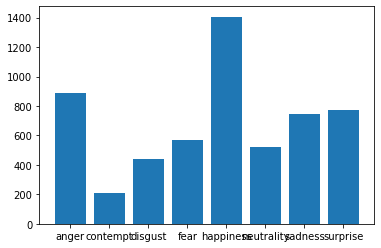

In [13]:
bar = data._get_Klassenverteilung()
plt.bar(bar.keys(), bar.values())

In [14]:
s, t=data.__getitem__(65454)
s.shape

torch.Size([3, 22, 22])

In [15]:
type(plt.imread(data.image_dict["anger"][3]))

numpy.ndarray

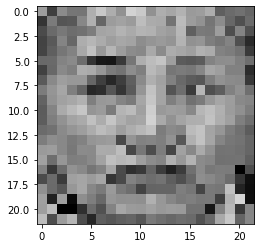

In [16]:
s, t = data.__getitem__(3)

plt.imshow(s.permute(1,2,0))

In [17]:
# Augmentations definieren
test_transformations = T.Compose([
    T.ColorJitter(brightness=(0.8,1.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=45),
    T.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    T.RandomCrop(size=(180,180), fill=0, padding_mode="constant")
])

In [18]:
data = myFaceImageDataset(path_to_img=path_to_gesamt, emotion_list=targets, 
                            cartoon_filter="no_filter", balanced_sampling=True, 
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=test_transformations )

In [19]:
data.epoch_length

5552

In [20]:
s, t = data.__getitem__(0)

In [21]:
data.IndexMappingList

OrderedDict([('anger', 890),
             ('contempt', 1098),
             ('disgust', 1537),
             ('fear', 2107),
             ('happiness', 3513),
             ('neutrality', 4037),
             ('sadness', 4783),
             ('surprise', 5558)])

happiness


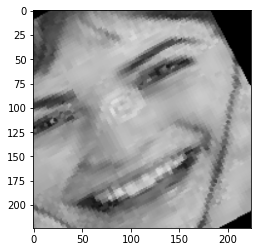

In [22]:
s, t = data.__getitem__(4276)
print(data._vector2word(t["class"]))
plt.imshow(s.permute(1,2,0))

In [23]:
type(s)

torch.Tensor

In [24]:
data = myFaceImageDataset(path_to_img=path_to_gesamt, emotion_list=targets, 
                            cartoon_filter="cartoonify", balanced_sampling=True, 
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=test_transformations )

happiness


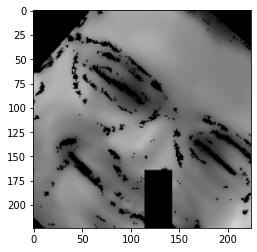

In [25]:
s, t = data.__getitem__(4276)
print(data._vector2word(t["class"]))
plt.imshow(s.permute(1,2,0))

<class 'numpy.ndarray'>
(224, 224, 3)


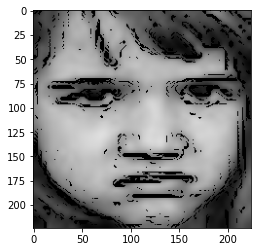

In [26]:
u = cartoonify(data.image_dict["anger"][32])
print(type(u))
print(u.shape)
plt.imshow(u)

<class 'torch.Tensor'>
torch.Size([224, 224, 3])


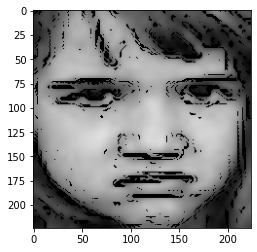

In [27]:
u = u / 255
u = torch.tensor(u, dtype=torch.float32)
print(type(u))
print(u.shape)
plt.imshow(u)

___
## Setting up the Model

Dokumentation dazu: https://pytorch.org/vision/0.11/models.html

In [28]:
# Definition of the net structure
class Net(torch.nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.n_classes = n_classes

        # Resnet Featureextractor Laden, ich werfe hier den großen LinearLayer am Ende von dem Resnet weg
        self.fe = torch.nn.Sequential(*(list(torchvision.models.resnet18(pretrained=True).children())[:-1]))
        # Die Featur Map die aus dem Resnet raus kommt hat eine Größe von batch_size x 512 x 1 x 1
        # -> Das bringen wir nacher in der forward Mehtode noch auf die richtige Dimension

        # dein Lienar Layer muss aber 512 Eingänge haben
        self.fe2 = torch.nn.Sequential(torch.nn.Linear(512, 16),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(0.8),
                                        torch.nn.Linear(16, self.n_classes))

        # Dropout sorgt für Regularisierung, gegen Overfitting

    def forward(self, x):
        # den squeeze braucht man, weil die Feature Map eine Größe von batch_size x 512 x 1 x 1 hat,
        # die wird damit reduziert auf batch_size x 512
        y_pred = self.fe2(self.fe(x).squeeze())

        return y_pred

# Modelltraining

Interessante Dokumentationen:\
[BCEWithLogitsLoss — PyTorch 1.11.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)\
[torch.nn.functional.one_hot — PyTorch 1.11.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)\
https://pytorch.org/docs/stable/data.html \
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html \
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html \
[Data Augmentation](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html)\
[Optimizing Model Parameters](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)\
[Modelle einfrieren](https://pytorch.org/docs/master/notes/autograd.html)

Falls der DataLoader rummeckert müsste ich mir eine "costum collate fnc" erstellen (ins Dataset)

In [29]:
def train(net, train_l, vali_l, optim, crit):
    bce_train = []
    bce_vali = []
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.to(device)

    for epoch in tqdm(range(0, epochen )):
        net.train()
        
        for b_idx, (dat, tar) in enumerate(train_l):
            t = tar["class"]
            # --- Training ----#
            optim.zero_grad()

            dat = dat.to(device)
            y_pred = net(dat)

            y_pred = y_pred.to(device)
            t = t.to(device)
            train_loss = crit(y_pred, t)

            train_loss.backward()
            
            optim.step()
            

            # ----- Evaluation metrics train ---- #
            bce_train.append(train_loss.item())
        

        
        # ----- Test Prediction & Evaluation -------------#
        net.eval()
        summ = []
        c = 0
        for b_idx, (dat, tar) in enumerate(vali_l):
            t = tar["class"]

            optim.zero_grad()

            dat = dat.to(device)
            y_pred = net(dat)

            y_pred = y_pred.to(device)
            t = t.to(device)
            vali_loss = crit(y_pred, t)            

            summ.append(vali_loss.item())
            c += 1
                
        bce_vali.append(sum(summ)/c)


    net.eval()

    return net, bce_train, bce_test   

### Vorbereitung

In [30]:
# Hyperparameter festlegen
learning_rate = 0.001
batch_size = 2
epochen = 20


In [31]:
my_model = Net(8)

#friert das pretrained ResNet ein
for param in my_model.fe.children():
    param.requires_grad_ = False

optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
criterium =  torch.nn.BCEWithLogitsLoss()

In [32]:
# Augmentations definieren
aug_transformations = T.Compose([
    T.ColorJitter(brightness=(0.8,1.2)),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=45),
    T.RandomErasing(p=0.3, scale=(0.02, 0.20)),
    T.RandomCrop(size=(180,180), fill=0, padding_mode="constant")
])

In [33]:
path_to_train = path_folder + "/Training"
data_train = myFaceImageDataset(path_to_img=path_to_train, emotion_list=targets, 
                            cartoon_filter="no_filter", balanced_sampling=True, 
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=aug_transformations)
path_to_vali = path_folder + "/Validierung"
data_val = myFaceImageDataset(path_to_img=path_to_vali, emotion_list=targets, 
                            cartoon_filter="no_filter", balanced_sampling=False,   
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=None)
                            # Es macht, denke ich, wenig Sinn bei den Validierungsdaten darauf zu achten,
                            # dass alle Klassen gleichmäßig gezogen werden.
                            # Genau so sind Augmentierungen hier nicht von Nöten

In [34]:
# Daten in den Dataloader packen

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size = batch_size,
    shuffle = True
)

val_loader = torch.utils.data.DataLoader(
    data_val,
    batch_size = batch_size,
    shuffle = False
)

### Durchführung

In [35]:
my_model, bce_train, bce_test = train(my_model, train_loader, val_loader, optimizer, criterium)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
path_to_valiModel = path_folder + "/Validierungsmodel"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

torch.save(my_model.state_dict(), path_to_valiModel)
valiModel = Net(8)
valiModel.load_state_dict(torch.load(path_to_valiModel, map_location=device))

NameError: name 'my_model' is not defined

In [ ]:
bce_train_arr = np.array(bce_train)
bce_test_arr = np.array(bce_test)
x_train = np.linspace(0,epochen,bce_train_arr.size)
x_test = np.linspace(0,epochen,bce_test_arr.size)


plt.figure(figsize=(10,7))

plt.plot(x_train, bce_train_arr,        color="navy", label="Train Error")
plt.plot(x_test, bce_test_arr,  "r--", color="red",  label="Test Error" )
plt.legend()
plt.show()

### Konfusionsmatrix

Zuerst: Wieviele Trainingsdaten werden richtig klassifiziert?

In [ ]:
# Als Vorbereitung für die Konfusionsmatrix
def get_Predictionvector_GTruthvector(data_set, model):

    pred  = []
    truth = []

    for i in (0, len(data_set)):
        s, t = data_set.__getitem__(i)
        i_truth = vector2word(t["class"])

        i_pred = model(s)
        i_pred = vector2word(max_Vektor(i_pred))

        pred.append(i_pred)
        truth.append(i_truth)

    return pred, truth


In [ ]:
train_pred, train_truth = get_Predictionvector_GTruthvector(data_train, valiModel)

Wieviele Validierungsdaten werden richtig klassifiziert?

In [ ]:
train_pred, train_truth = get_Predictionvector_GTruthvector(data_val, valiModel)

___
## Trainieren auf den gesamten Daten

Nach der Evaluierung des Modells möchte ich noch auf noch auf den gesamten, verfügbaren Daten trainieren.

In [ ]:
train_data_real = myFaceImageDataset(path_to_img=path_to_gesamt, emotion_list=targets, 
                            cartoon_filter="no_filter", balanced_sampling=True,   
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=aug_transformations)

In [ ]:
model_real = Net(8)

#friert das pretrained ResNet ein
for param in model_real.fe.children():
    param.requires_grad_ = False

optimizer = torch.optim.Adam(model_real.parameters(), lr=learning_rate)
criterium = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_loader_real = torch.utils.data.DataLoader(
    train_data_real,
    batch_size = batch_size,
    shuffle = True
)


In [ ]:
model_real, bce_train, _ = train(model_real, train_loader_real, None, optimizer, criterium)

In [ ]:
path_to_realModel = path_folder + "/EmoClassifier_Real"

In [ ]:
torch.save(model_real.state_dict(), path_to_realModel)

Jetzt auch noch mit dem Cartoonify-Filter

In [ ]:
train_data_cart = myFaceImageDataset(path_to_img=path_to_gesamt, emotion_list=targets, 
                            cartoon_filter="cartoonify", balanced_sampling=True,   
                            standard_imagesize=(224, 224), isGrayScale=False, transforms=aug_transformations)

In [ ]:
model_cart = Net(8)

#friert das pretrained ResNet ein
for param in model_cart.fe.children():
    param.requires_grad_ = False

optimizer = torch.optim.Adam(model_cart.parameters(), lr=learning_rate)
criterium =  torch.nn.BCEWithLogitsLoss()

In [ ]:
train_loader_cart = torch.utils.data.DataLoader(
    train_data_cart,
    batch_size = batch_size,
    shuffle = True
)


In [ ]:
model_cart, bce_train, _ = train(model_cart, train_loader_cart, None, optimizer, criterium)

In [ ]:
path_to_cartModel = path_folder + "/EmoClassifier_Cart"

In [ ]:
torch.save(model_cart.state_dict(), path_to_cartModel)

## Testgebiet

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier_real = Net(8)
classifier_real.load_state_dict(torch.load(path_to_realModel, map_location=device))

In [ ]:
classifier_cart = Net(8)
classifier_cart.load_state_dict(torch.load(path_to_cartModel, map_location=device))

In [66]:
# füge RGB hinzu
# von (y, x) zu (y, x, c)
def add_RGBLayers(im):
    if len(im.shape) == 3:
        return im
    elif len(im.shape) == 2:
        return np.stack((im, im, im), 2)

In [67]:
def load_data(path_folder, add_RGB=False):
    #Loading the data into a the Notebook
    data = {}
    count = 0

    for t in targets:    
        p = path_folder + "/" + t
        #print(t)
        for filename in os.listdir(p):

            f = os.path.join(p,filename)
            if os.path.isfile(f):

                # the sample is save on the 0. position and the target on the 1. position
                x = plt.imread(f)
                
                x = x[:,:,:3]
                #print(count)
                #print(filename)
                if add_RGB: 
                    x = add_RGBLayers(x)

                

                x = torch.tensor(x, dtype=torch.float32)
                data[count] = (x, word2vector(t))

                count += 1
    #format:

    return data

In [68]:
path_to_testbilder = path_folder + "/Testbilder"
testbilder = load_data(path_to_testbilder, True)
len(testbilder)

8

In [ ]:
modelR = Net(8)
modelR.load_state_dict(torch.load(path_to_realModel))

modelC = Net(8)
modelC.load_state_dict(torch.load(path_to_cartModel))

In [79]:
def testoutput(test_dict, model=None):
    n = len(test_dict) # number of images
    start_pos = 0
    plt.figure(figsize=(20,20))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.tight_layout()
        plt.imshow(test_dict[i][0], cmap='gray')
        plt.title(vector2word(test_dict[i][1]))
        plt.xticks([])
        plt.yticks([])
        if model != None:
            t = model(test_dict[i][0])
            ta = vector2word(max_Vektor(t))
            plt.text(20, 20, ( t , "\n", ta ))
    plt.show()

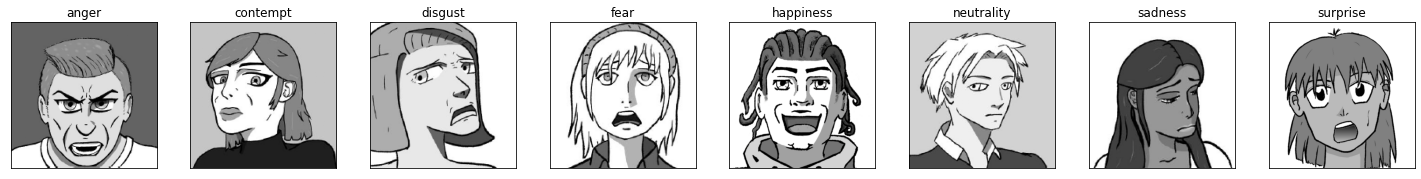

In [80]:
testoutput(testbilder)